In [34]:
import pandas as pd
import sys
import os
from typing import List
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib as plt
import numpy
#shapiro  mostra se os dados que vem de uma distribuicao normal, se sao provenientes ou nao

In [11]:

df = pd.read_csv("sistema.csv", sep=";",encoding='cp1252')

In [12]:
def clear_df(df):
    df[["day", "month", "year"]] = df["Data"].str.split("/", expand = True)
    df = df.drop("Data", axis=1)
    return df

In [13]:
def tranform_to_float(df:pd.DataFrame, cols:List[str]):
    df_c = clear_df(df)
    for col in df_c:
      if col in cols:
        df_c[col] = df_c[col].str.replace(',', '.').astype(float)
    return df_c    

In [14]:
def transform_names(df:pd.DataFrame, cols:List[str], new_col_names:List[str]):
    df_tranf = tranform_to_float(df, cols)
    df_tranf.columns = new_col_names
    return df_tranf

### Análise Descritiva (EDA)

#### Outliers

In [15]:
df = transform_names(df = df, cols =["N’vel (m)","Volume (hm_)","Volume (%)","Q Jusante (m_/s)","Q Natural (m_/s)","Chuva (mm)"] , new_col_names=["VrNivel" , "VlVolumeHm", "VrVolume%", "VlQJusante", "VlQNatural","VrChuva", "DdDia", "MmMes", "AaAno"])

<Axes: xlabel='VrNivel'>

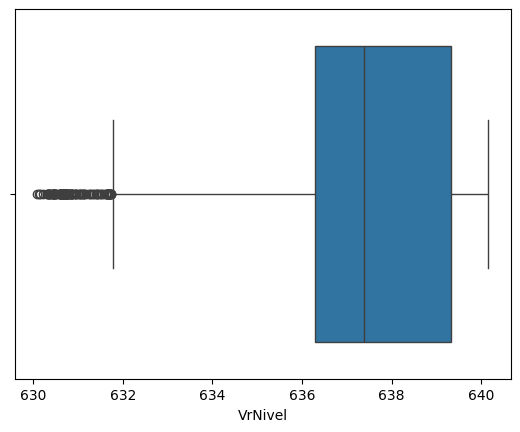

In [258]:
sns.boxplot(x= df["VrNivel"])
#df_desc = df_desc.drop(df_desc[(df_desc.VrNivel < 632)].index)

<Axes: xlabel='VlVolumeHm'>

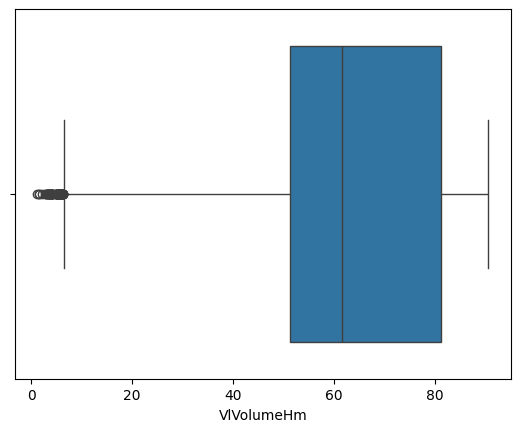

In [259]:
sns.boxplot(x= df["VlVolumeHm"])
#df = df.drop(df[(df.VrNivel < 632)].index)

<Axes: xlabel='VrVolume%'>

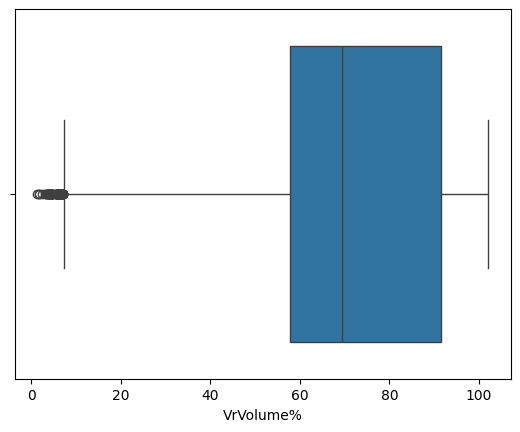

In [260]:
sns.boxplot(x= df["VrVolume%"])
#df = df.drop(df[(df.VrNivel < 632)].index)

<Axes: xlabel='VlQJusante'>

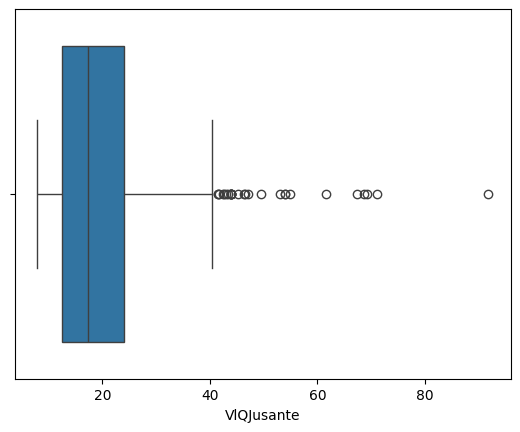

In [262]:
sns.boxplot(x= df["VlQJusante"])
#df = df.drop(df[(df.VlQJusante >40)].index)

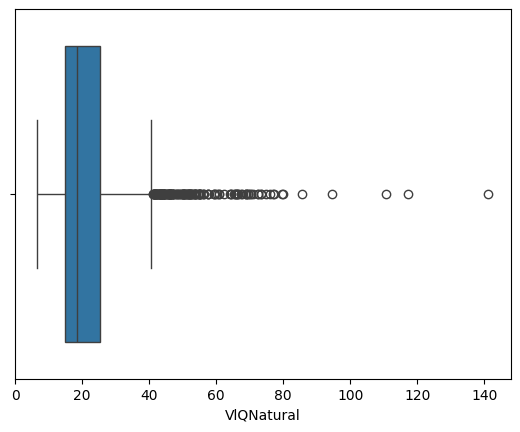

In [263]:
sns.boxplot(x= df["VlQNatural"])
df = df.drop(df[(df.VlQNatural >40)].index)

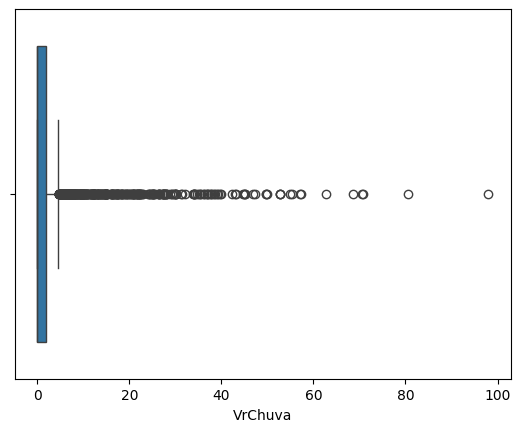

In [264]:
sns.boxplot(x= df["VrChuva"])
df = df.drop(df[(df.VrChuva >8)].index)

In [266]:
def create_abt(df,cols,new_col_names):
    df_tranf =  transform_names(df,cols,new_col_names)
    df_tranf = df_tranf.drop(df_tranf[(df_tranf.VrNivel < 632)].index)
    df_tranf = df_tranf.drop(df_tranf[(df_tranf.VlQJusante >40)].index)
    df_tranf = df_tranf.drop(df_tranf[(df_tranf.VlQNatural >40)].index)
    df_tranf = df_tranf.drop(df_tranf[(df_tranf.VrChuva >8)].index)
    return df_tranf

### Nulos

In [267]:
df_nulls = create_abt(df = df, cols =["N’vel (m)","Volume (hm_)","Volume (%)","Q Jusante (m_/s)","Q Natural (m_/s)","Chuva (mm)"] , new_col_names=["VrNivel" , "VlVolumeHm", "VrVolume%", "VlQJusante", "VlQNatural","VrChuva", "DdDia", "MmMes", "AaAno"])

KeyError: 'Data'

In [238]:
df_nulls.isnull().sum()

VrNivel       0
VlVolumeHm    0
VrVolume%     0
VlQJusante    0
VlQNatural    0
VrChuva       0
DdDia         0
MmMes         0
AaAno         0
dtype: int64

In [239]:
df_nulls

,VrNivel,VlVolumeHm,VrVolume%,VlQJusante,VlQNatural,VrChuva,DdDia,MmMes,AaAno
0,639.07,78.586214,88.476788,15.82,23.066807,0.2,01,07,2023
1,639.04,78.266134,88.116424,15.85,18.787148,2.8,30,06,2023
2,639.05,78.372760,88.236469,15.55,16.450565,0.0,29,06,2023
3,639.07,78.586214,88.476788,16.21,17.565766,0.2,28,06,2023
4,639.09,78.799940,88.717412,11.94,15.719460,0.2,27,06,2023
...,...,...,...,...,...,...,...,...,...
2187,638.21,69.644882,78.410133,21.25,18.905209,0.0,05,07,2017
2188,638.23,69.847472,78.638220,21.08,17.557459,0.0,04,07,2017
2189,638.26,70.151820,78.980872,20.41,19.234388,5.0,03,07,2017
2190,638.27,70.253393,79.095228,20.37,15.660373,0.0,02,07,2017


### Distribuiçao dos Dados
- Os dados precisam ter uma destribuição normal

<Axes: >

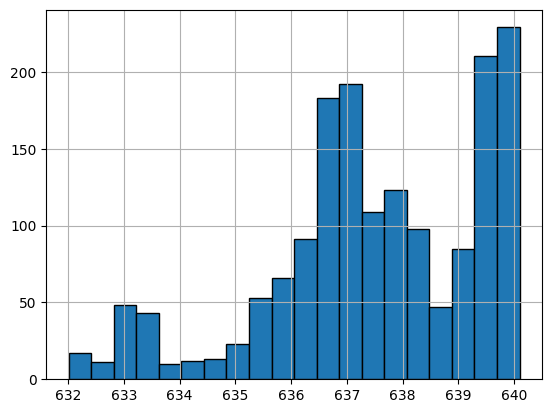

In [240]:
df_nulls["VrNivel"].hist(edgecolor="black", bins=20)

In [131]:
# para considerarmos que os dados sao provenientes de uma distribuicao normal o P Valor precisa ser inferior a 0.05
# para uma reg linear 
shapiro(df_nulls["VrNivel"])

ShapiroResult(statistic=0.9293246865272522, pvalue=2.5411407243235336e-27)

In [270]:
def test_normal(df, cols, new_col_names):
    df = create_abt(df, cols, new_col_names)
    for col in df:
        if shapiro(df[col]).pvalue >= 0.05:
            print(f"coluna {col} {shapiro(df[col]).pvalue}.É Normal")
        print(f"coluna {col} {shapiro(df[col]).pvalue}. Não Normal")

In [271]:
create_abt(df = df, cols =["N’vel (m)","Volume (hm_)","Volume (%)","Q Jusante (m_/s)","Q Natural (m_/s)","Chuva (mm)"] , new_col_names=["VrNivel" , "VlVolumeHm", "PcVolume%", "VzQJusante", "VzQNatural","VrChuva", "DdDia", "MmMes", "AaAno"])

coluna VrNivel 2.5411407243235336e-27. Não Normal
coluna VlVolumeHm 1.0541436849865518e-24. Não Normal
coluna VrVolume% 1.0536989646512335e-24. Não Normal
coluna VlQJusante 1.0517226950027382e-30. Não Normal
coluna VlQNatural 1.6562250020170563e-28. Não Normal
coluna VrChuva 0.0. Não Normal


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [24]:
#sklearn.preprocessing() StandardScaler
fitted_data, fitted_lambda = stats.boxcox(df["VrNivel"])



/Users/lucaszanforlin/Library/Caches/pypoetry/virtualenvs/modelo-sabesp-ccLZWcER-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/lucaszanforlin/Library/Caches/pypoetry/virtualenvs/modelo-sabesp-ccLZWcER-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [ ]:
def normalizer(df):
   for col in df:
      n = f"{df[col]}, {fitted_lambda} = {stats.boxcox(df[col])}
      print(n)

In [29]:
print(type(fitted_data))

<class 'numpy.ndarray'>


In [26]:
shapiro(fitted_data)

/Users/lucaszanforlin/Library/Caches/pypoetry/virtualenvs/modelo-sabesp-ccLZWcER-py3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:1877: RuntimeWarning: overflow encountered in cast
  a, w, pw, ifault = _statlib.swilk(y, a[:N//2], init)


ShapiroResult(statistic=nan, pvalue=1.0)

In [36]:

plt(fitted_data.squeeze())
plt.show()





TypeError: 'module' object is not callable

In [28]:
fitted_data

array([1.71844829e+153, 1.71399780e+153, 1.71548004e+153, ...,
       1.60217639e+153, 1.60356362e+153, 1.60912434e+153])